In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from PIL import Image
import numpy as np

In [2]:
# Define image size
img_size = 45

# Define transformations for training data (you might augment more here later)
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize pixel values to [-1, 1]
])

# Define transformations for test data (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [3]:
data_dir = '/Users/gvklok/Documents/CST-425/MathSolver/Dataset' # Assuming your 'train' and 'test' folders are inside this
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Get the class names (directory names)
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['decimal', 'div', 'eight', 'equal', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']
Number of classes: 16


In [4]:
batch_size = 32  # You can adjust this based on your GPU memory (if you have one) or preference

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle the test set

In [5]:
class CharacterRecognizerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterRecognizerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the flattened layer
        self.fc1_input_size = 128 * (img_size // (2**3)) * (img_size // (2**3)) # img_size divided by 2 three times for three pooling layers
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

        # Store the img_size for the forward pass
        self.img_size = img_size

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.fc1_input_size) # Flatten the tensor
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CharacterRecognizerCNN(num_classes)

# Check if mac metak is available and use it if so
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: mps


In [6]:
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is a common and effective optimizer

In [7]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=5):
    model.train() # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Reset gradients from the previous iteration

            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate the loss

            loss.backward() # Backpropagation: compute gradients
            optimizer.step() # Update model weights

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1) # Get the index of the max probability
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Set the number of training epochs
num_epochs = 10 # You can adjust this number

# Call the train function
train(model, train_loader, criterion, optimizer, device, num_epochs)

print("Finished Training")
torch.save(model.state_dict(), "character_recognizer.pth")
print("Model saved to character_recognizer.pth")

Epoch [1/10], Loss: 0.9293, Accuracy: 0.7131
Epoch [2/10], Loss: 0.2222, Accuracy: 0.9315
Epoch [3/10], Loss: 0.1000, Accuracy: 0.9673
Epoch [4/10], Loss: 0.0733, Accuracy: 0.9784
Epoch [5/10], Loss: 0.0398, Accuracy: 0.9884
Epoch [6/10], Loss: 0.0233, Accuracy: 0.9927
Epoch [7/10], Loss: 0.0517, Accuracy: 0.9865
Epoch [8/10], Loss: 0.0389, Accuracy: 0.9874
Epoch [9/10], Loss: 0.0107, Accuracy: 0.9972
Epoch [10/10], Loss: 0.0178, Accuracy: 0.9950
Finished Training
Model saved to character_recognizer.pth


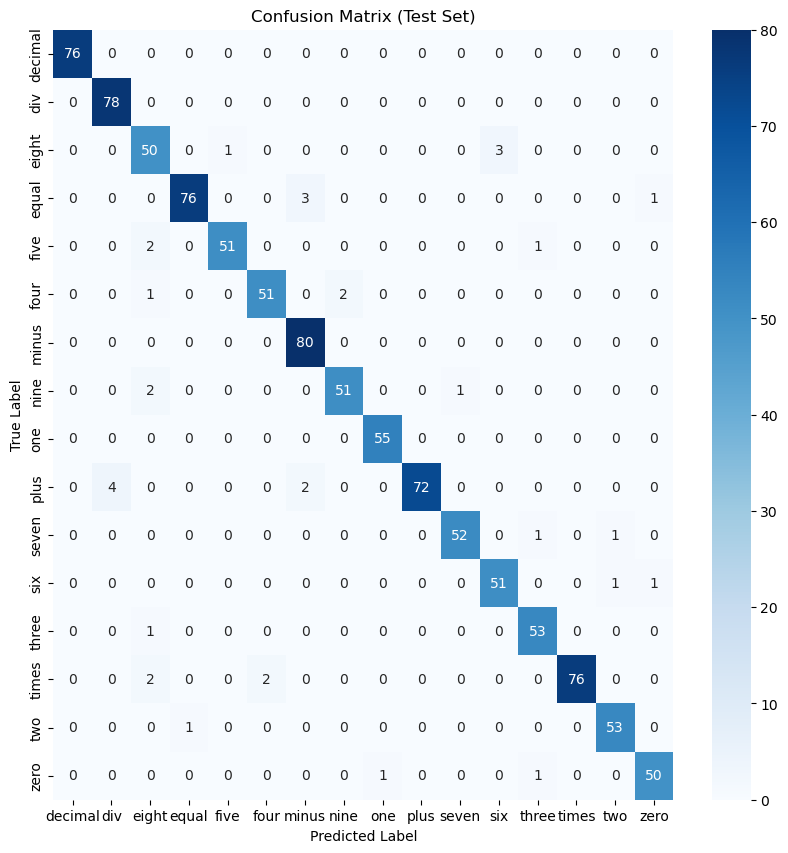

Overall Test Accuracy: 0.9653
Finished Evaluation


In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, test_loader, device, class_names):
    model.eval() # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Calculate and print overall test accuracy
    overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Evaluate the model
evaluate(model, test_loader, device, class_names)

print("Finished Evaluation")